# Doughnut Identification CNN

In [2]:
#https://github.com/NicholasConsiglio1201/Donut_Detection

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
import shutil
import warnings
import uuid
import gradio as gr

# Suppress warnings
warnings.filterwarnings('ignore')


2024-09-25 23:16:38.926575: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 23:16:38.969483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 23:16:38.969511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 23:16:38.970511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 23:16:38.977089: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset_dir = 'doughnuts/images'
class_names = ['cake_batter', 'chocolate_glazed', 'chocolate_glazed_sprinkles', 
               'original_glazed', 'strawberry_glazed_sprinkles']


In [3]:
# Function to apply blurriness
def apply_blur(img, radius=2):
    return img.filter(ImageFilter.GaussianBlur(radius))

# Function to apply shadow (darken the image)
def apply_shadow(img, factor=0.5):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

In [4]:
# Function to clean a directory (to prevent data duplication)
def clean_directory(target_path):
    if os.path.exists(target_path):
        shutil.rmtree(target_path)
    os.makedirs(target_path, exist_ok=True)

In [5]:
# Function to split data into train (80%) and test (20%) sets
def gen_train_test_split(path_to_imgs='doughnuts/images', target_path='doughnuts_split', train_ratio=0.8):
    clean_directory(os.path.join(target_path, 'train'))
    clean_directory(os.path.join(target_path, 'test'))
    
    # Iterate over each class and split the images
    for category in class_names:
        print(f"Processing category: {category}")
        train_category_path = os.path.join(target_path, 'train', category)
        test_category_path = os.path.join(target_path, 'test', category)
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(test_category_path, exist_ok=True)
        
        category_img_path = os.path.join(path_to_imgs, category)
        images = os.listdir(category_img_path)
        
        # Ensure there are images in the directory
        if len(images) == 0:
            print(f"No images found in {category_img_path}")
            continue
        
        random.shuffle(images)  # Randomize the order of the images
        
        # Determine the train/test split ratio
        train_split = int(train_ratio * len(images))  # 80% for training
        print(f"Splitting {len(images)} images in {category}: {train_split} for training, {len(images) - train_split} for testing")
        
        # Copy images to the train directory
        for img in images[:train_split]:
            shutil.copy(os.path.join(category_img_path, img), os.path.join(train_category_path, img))
        
        # Copy images to the test directory
        for img in images[train_split:]:
            shutil.copy(os.path.join(category_img_path, img), os.path.join(test_category_path, img))


In [6]:
# Function to copy original test data (no augmentation)
def copy_test_data(path_to_test_imgs='doughnuts_split/test', target_path='doughnuts_balanced_train/test'):
    clean_directory(target_path)
    
    for category in class_names:
        category_path = os.path.join(path_to_test_imgs, category)
        target_category_path = os.path.join(target_path, category)
        os.makedirs(target_category_path, exist_ok=True)
        
        # Copy images to the target test path
        images = os.listdir(category_path)
        for img in images:
            shutil.copy(os.path.join(category_path, img), os.path.join(target_category_path, f'{uuid.uuid4().hex}_{img}'))


In [7]:
# Function to augment and rename training images to match the size of the largest class
def augment_train_images(path_to_imgs='doughnuts_split/train', target_path='doughnuts_balanced_train/train', max_images_per_class=109):
    clean_directory(target_path)
    
    for category in class_names:
        category_path = os.path.join(path_to_imgs, category)
        target_category_path = os.path.join(target_path, category)
        os.makedirs(target_category_path, exist_ok=True)
        
        images = os.listdir(category_path)
        current_count = len(images)
        
        # Copy original images to the target path
        for img in images:
            shutil.copy(os.path.join(category_path, img), os.path.join(target_category_path, img))
        
        # Augment if fewer than max_images_per_class
        while current_count < max_images_per_class:
            img = random.choice(images)
            img_path = os.path.join(category_path, img)
            img_pil = load_img(img_path)
            
            # Apply augmentations
            if random.random() > 0.5:
                aug_img = apply_blur(img_pil)
            else:
                aug_img = apply_shadow(img_pil)
            
            # Save the augmented image
            aug_img.save(os.path.join(target_category_path, f'aug_{uuid.uuid4().hex}.jpg'))
            current_count += 1


In [8]:
# Function to verify the structure of the dataset
def verify_dataset_structure(target_path='doughnuts_balanced_train'):
    for folder in ['train', 'test']:
        print(f"Verifying {folder} split:")
        for category in class_names:
            category_path = os.path.join(target_path, folder, category)
            if os.path.exists(category_path):
                images = os.listdir(category_path)
                print(f"{category}: {len(images)} images")
            else:
                print(f"{category_path} is missing")

In [9]:
# Example workflow:
gen_train_test_split('doughnuts/images', 'doughnuts_split', train_ratio=0.8)  # Step 1: Split the dataset into train and test
augment_train_images('doughnuts_split/train', 'doughnuts_balanced_train/train', max_images_per_class=109)  # Step 2: Augment training images
copy_test_data('doughnuts_split/test', 'doughnuts_balanced_train/test')  # Step 3: Copy test images without augmentation
verify_dataset_structure('doughnuts_balanced_train')  # Step 4: Verify final dataset structure


Processing category: cake_batter
Splitting 63 images in cake_batter: 50 for training, 13 for testing
Processing category: chocolate_glazed
Splitting 102 images in chocolate_glazed: 81 for training, 21 for testing
Processing category: chocolate_glazed_sprinkles
Splitting 98 images in chocolate_glazed_sprinkles: 78 for training, 20 for testing
Processing category: original_glazed
Splitting 137 images in original_glazed: 109 for training, 28 for testing
Processing category: strawberry_glazed_sprinkles
Splitting 101 images in strawberry_glazed_sprinkles: 80 for training, 21 for testing
Verifying train split:
cake_batter: 109 images
chocolate_glazed: 109 images
chocolate_glazed_sprinkles: 109 images
original_glazed: 109 images
strawberry_glazed_sprinkles: 109 images
Verifying test split:
cake_batter: 13 images
chocolate_glazed: 21 images
chocolate_glazed_sprinkles: 20 images
original_glazed: 28 images
strawberry_glazed_sprinkles: 21 images


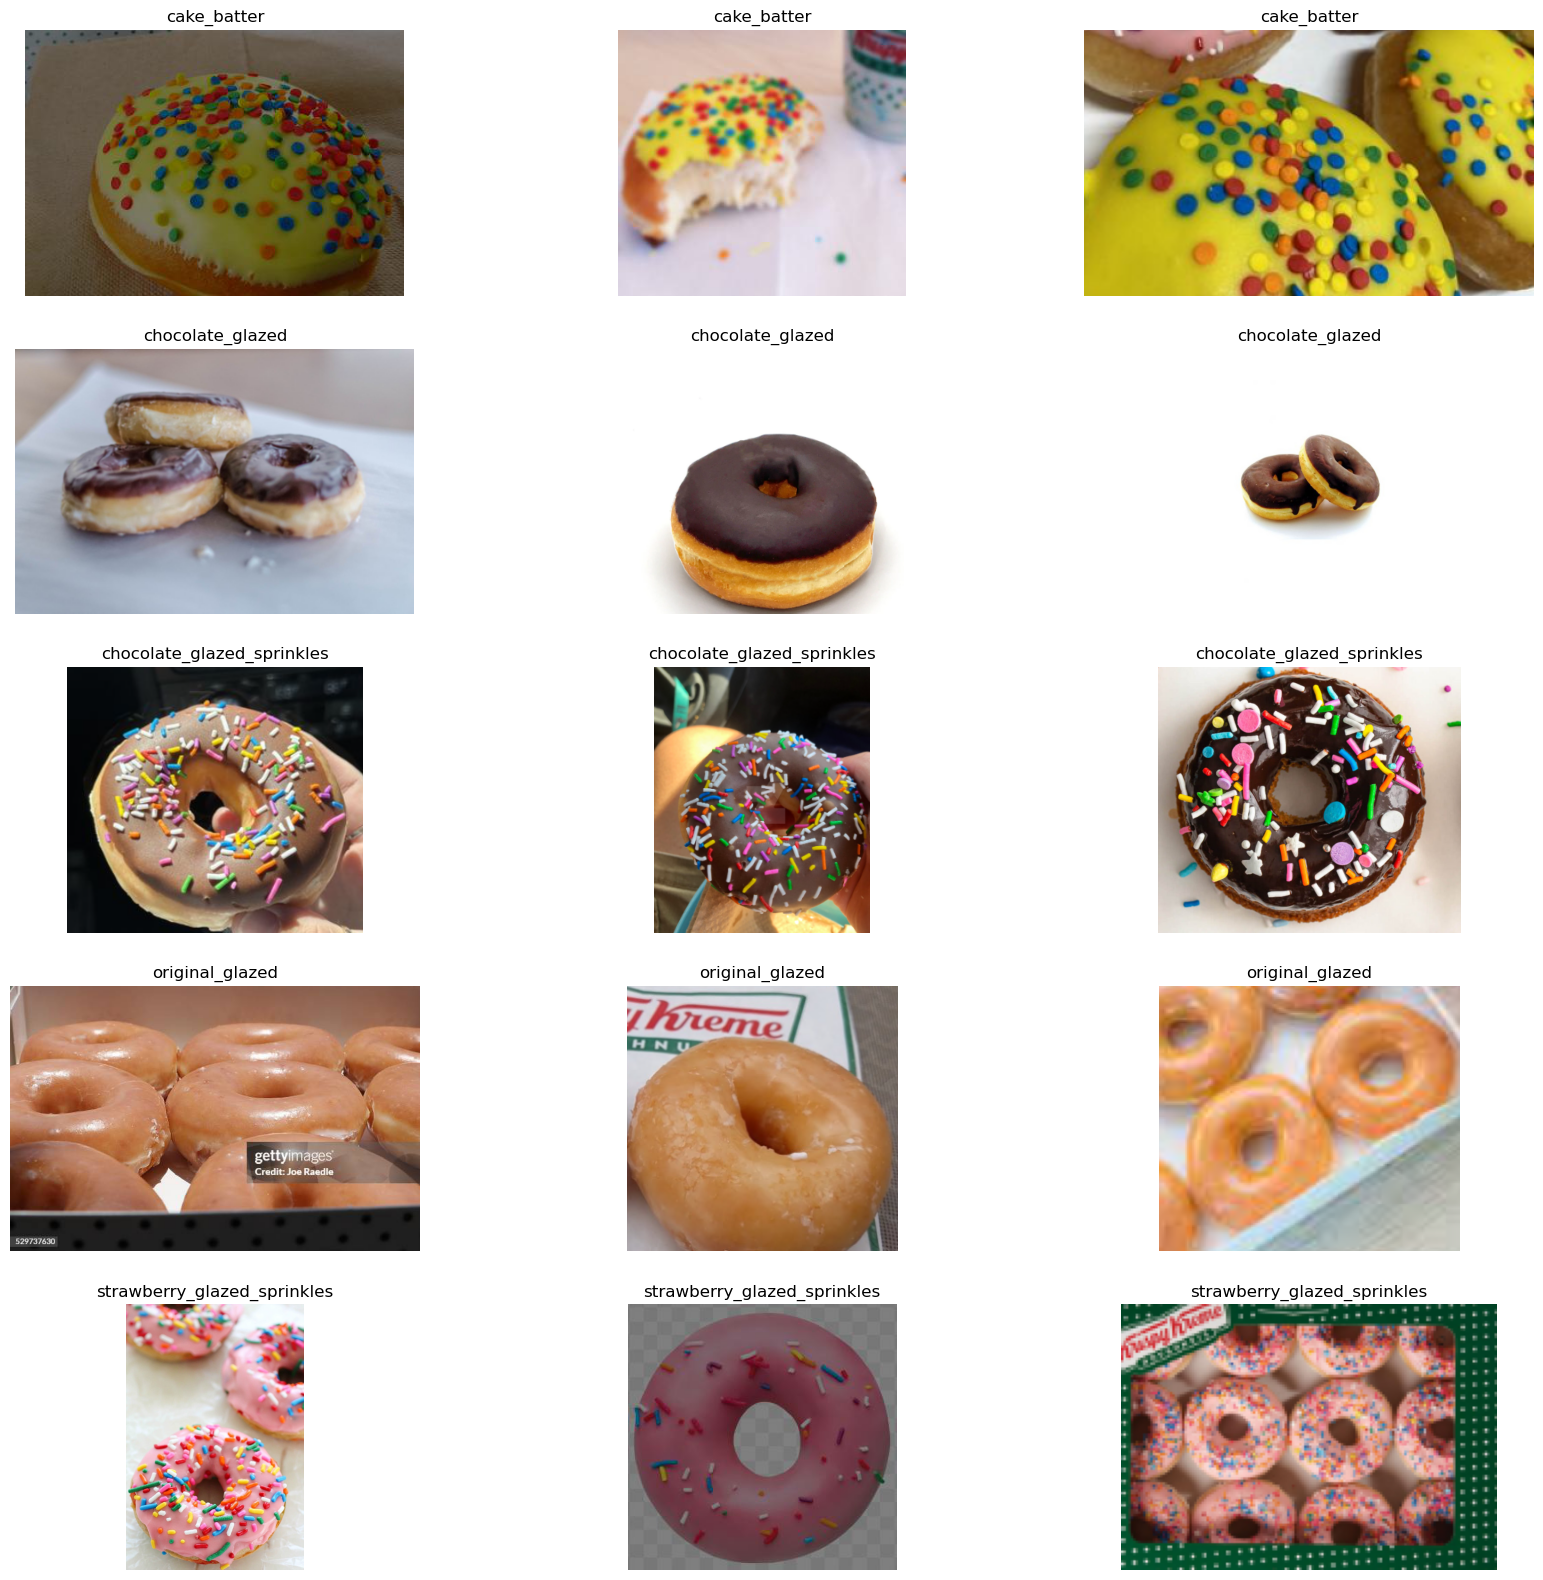

In [10]:
# Visualize 3 random images from each class (train set)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
train_dataset_dir = os.path.join('doughnuts_balanced_train', 'train')
images_per_class = 3
i = 0

for category in class_names:
    category_path = os.path.join(train_dataset_dir, category)
    example_imgs = os.listdir(category_path)
    random_imgs = random.sample(example_imgs, min(images_per_class, len(example_imgs)))

    for img_path in random_imgs:
        img = Image.open(os.path.join(category_path, img_path))
        ax = fig.add_subplot(5, 3, i + 1)
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')
        i += 1

plt.show()

In [11]:
# ImageDataGenerator for normalizing the images (we already performed augmentation offline)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path to the balanced training set and untouched test set
train_generator = train_datagen.flow_from_directory(
    os.path.join('doughnuts_balanced_train', 'train'),
    target_size=(400, 400),  # Resize to 299x299 for InceptionV3
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join('doughnuts_balanced_train', 'test'),
    target_size=(400, 400),  # Resize to 299x299 for InceptionV3
    batch_size=32,
    class_mode='categorical'
)


Found 545 images belonging to 5 classes.
Found 103 images belonging to 5 classes.


In [12]:
# Import InceptionV3 from Keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load the InceptionV3 model, excluding the top fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers in the base model (InceptionV3 pre-trained weights)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(5, activation='softmax')(x)  # Output layer for 5 classes

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [14]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)


Epoch 1/30
17/17 [==============================] - 17s 799ms/step - loss: 1.2018 - accuracy: 0.5404 - val_loss: 0.4954 - val_accuracy: 0.8542
Epoch 2/30
17/17 [==============================] - 12s 667ms/step - loss: 0.4309 - accuracy: 0.8616 - val_loss: 0.2130 - val_accuracy: 0.9583
Epoch 3/30
17/17 [==============================] - 12s 672ms/step - loss: 0.2590 - accuracy: 0.9103 - val_loss: 0.1618 - val_accuracy: 0.9479
Epoch 4/30
17/17 [==============================] - 12s 681ms/step - loss: 0.1730 - accuracy: 0.9532 - val_loss: 0.1051 - val_accuracy: 0.9688
Epoch 5/30
17/17 [==============================] - 11s 703ms/step - loss: 0.1281 - accuracy: 0.9688 - val_loss: 0.0964 - val_accuracy: 0.9792
Epoch 6/30
17/17 [==============================] - 11s 656ms/step - loss: 0.1009 - accuracy: 0.9747 - val_loss: 0.1002 - val_accuracy: 0.9583
Epoch 7/30
17/17 [==============================] - 11s 654ms/step - loss: 0.1335 - accuracy: 0.9571 - val_loss: 0.1125 - val_accuracy: 0.9583

In [15]:
# Save the model using the recommended Keras format
model.save('doughnut_model.keras')
model.save('doughnut_model.h5')

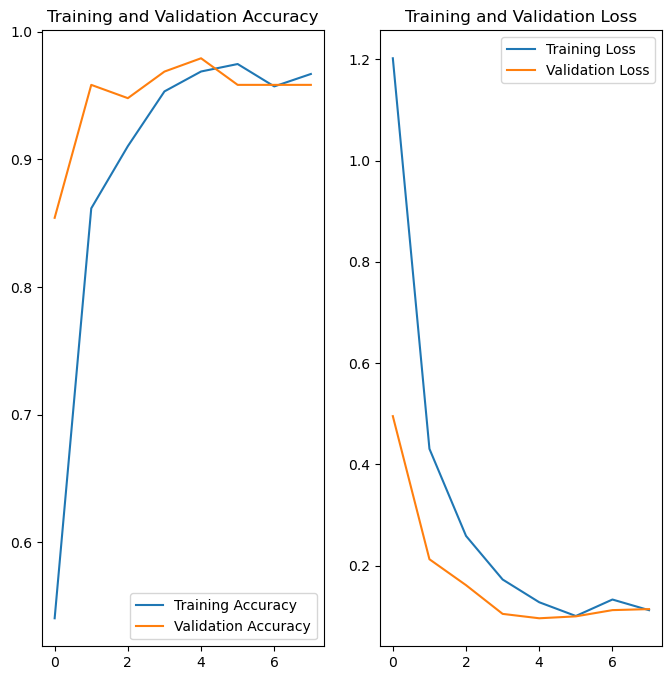

In [17]:
# Plot training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the range to cover all 40 epochs
epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



1/1 [==============================] - 1s 1s/step


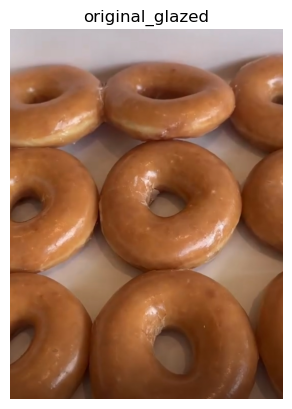

The model is 99.96% certain that the image is original_glazed
Prediction unavailable
1/1 [==============================] - 0s 63ms/step


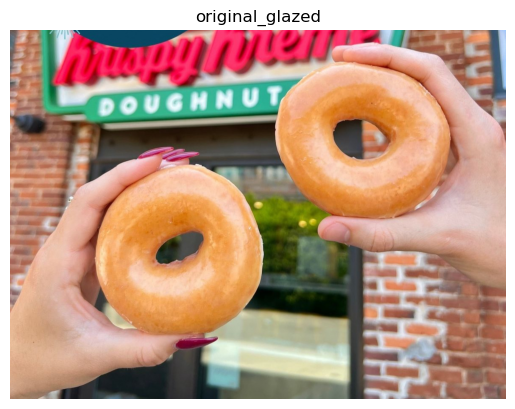

The model is 99.93% certain that the image is original_glazed
Prediction unavailable
1/1 [==============================] - 0s 60ms/step


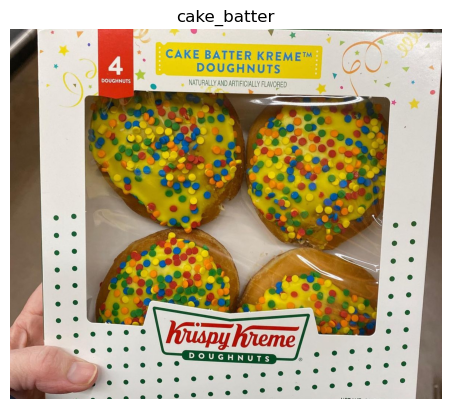

The model is 97.65% certain that the image is cake_batter
Prediction unavailable
1/1 [==============================] - 0s 61ms/step


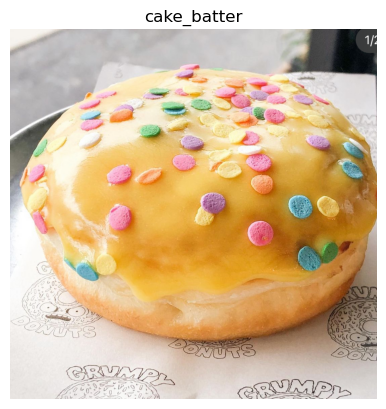

The model is 99.85% certain that the image is cake_batter
Prediction unavailable
1/1 [==============================] - 0s 60ms/step


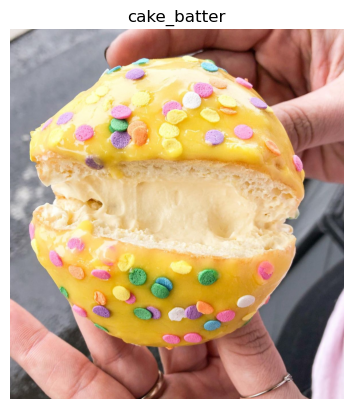

The model is 99.90% certain that the image is cake_batter
Prediction unavailable
1/1 [==============================] - 0s 59ms/step


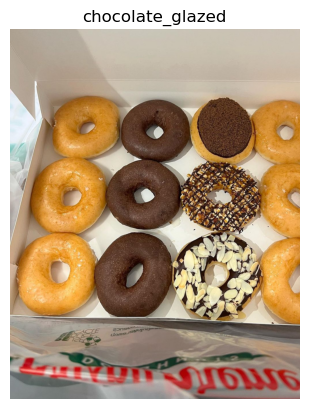

The model is 59.81% certain that the image is chocolate_glazed
Prediction unavailable
1/1 [==============================] - 0s 60ms/step


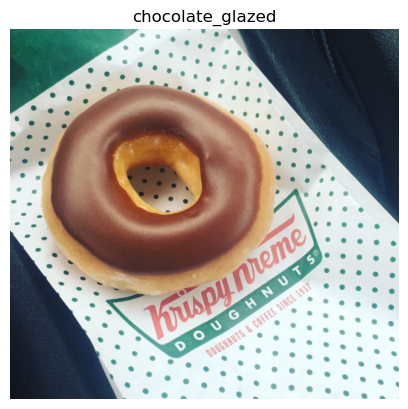

The model is 96.38% certain that the image is chocolate_glazed
Prediction unavailable
1/1 [==============================] - 0s 62ms/step


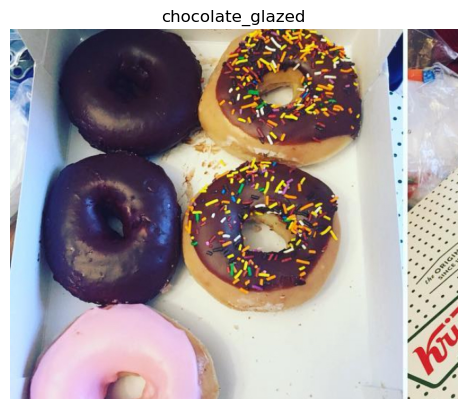

The model is 86.37% certain that the image is chocolate_glazed
Prediction unavailable
1/1 [==============================] - 0s 61ms/step


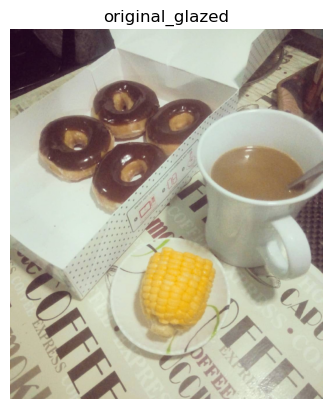

The model is 93.59% certain that the image is original_glazed
Prediction unavailable
1/1 [==============================] - 0s 62ms/step


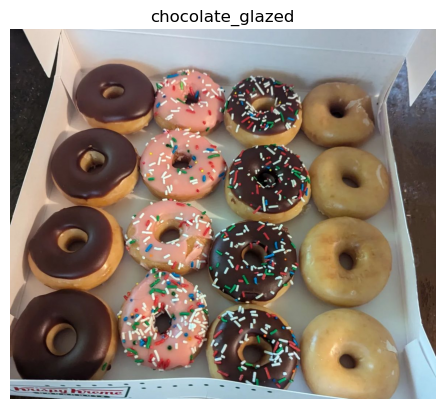

The model is 63.93% certain that the image is chocolate_glazed
Prediction unavailable
1/1 [==============================] - 0s 59ms/step


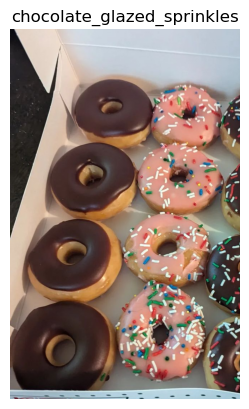

The model is 64.93% certain that the image is chocolate_glazed_sprinkles
Prediction unavailable
1/1 [==============================] - 0s 68ms/step


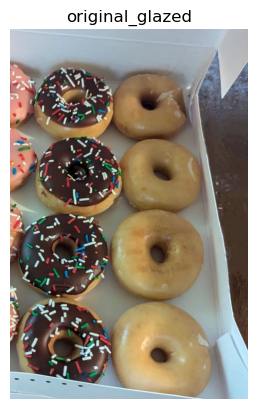

The model is 98.72% certain that the image is original_glazed
Prediction unavailable
1/1 [==============================] - 0s 60ms/step


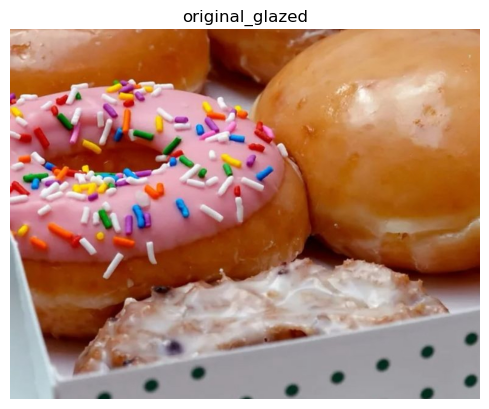

The model is 43.77% certain that the image is original_glazed
Prediction unavailable
1/1 [==============================] - 0s 58ms/step


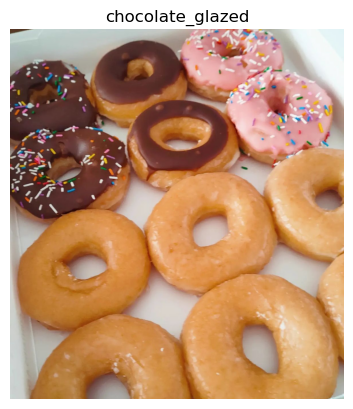

The model is 66.21% certain that the image is chocolate_glazed
Prediction unavailable


In [23]:
# Load the doughnut classification model
model_best = load_model('doughnut_model.keras', compile=False)

# Define the class map for your doughnut model
class_map_doughnuts = {
    0: 'cake_batter',
    1: 'chocolate_glazed',
    2: 'chocolate_glazed_sprinkles',
    3: 'original_glazed',
    4: 'strawberry_glazed_sprinkles'
}

# Function to get the class label from the index
def get_class_label(class_index):
    return class_map_doughnuts.get(class_index, "Unknown")

# Simplified function to predict the class of input images
def predict_class(model, images, class_map, show=True):
    for img_path in images:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make the prediction
        pred = model.predict(img_array)
        index = np.argmax(pred)
        pred_value = class_map.get(index, "Unknown")
        top_prob = np.max(pred) * 100

        # If the confidence is low, handle uncertain predictions
        if top_prob < 20:
            img_original = image.load_img(img_path)
            plt.imshow(img_original)
            plt.axis('off')
            plt.show()
            print("This image may not contain a food trained in this model or may not contain food, otherwise please retake the picture and try again.")
        else:
            # Display the image and prediction
            if show:
                img_original = image.load_img(img_path)
                plt.imshow(img_original)
                plt.axis('off')
                plt.title(pred_value)
                plt.show()

            print(f"The model is {top_prob:.2f}% certain that the image is {pred_value}")

            
            
# List of image paths
images = [
    'IMG_2698.jpeg',
    'IMG_2699.jpeg',
    'IMG_2700.jpeg',
    'IMG_2701.jpeg',
    'IMG_2702.jpeg',
    'IMG_2703.jpeg',
    'IMG_2704.jpeg',
    'IMG_2705.jpeg',
    'IMG_2706.jpeg',
    'IMG_2707.jpeg',
    'IMG_2708.jpeg',
    'IMG_2709.jpeg',
    'IMG_2710.jpeg',
    'IMG_2711.jpeg'
]

# Run predictions on the images
predict_class(model_best, images, class_map_doughnuts, True)


In [1]:
# Load the doughnut classification model
matts_donut_model = load_model('doughnut_model.h5', compile=False)

# Define the class map for your doughnut model
doughnuts = {
    0: 'cake_batter',
    1: 'chocolate_glazed',
    2: 'chocolate_glazed_sprinkles',
    3: 'original_glazed',
    4: 'strawberry_glazed_sprinkles'
}

# Function to predict class of a single input image
def predict_doughnut(img):
    # Resize the input image to 299x299 as expected by the model
    img = img.resize((299, 299))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Make the prediction
    pred = Matts_donut_model.predict(img_array)
    index = np.argmax(pred)
    pred_value = doughnuts.get(index, "Unknown")
    top_prob = np.max(pred) * 100

    return f"The model is {top_prob:.2f}% certain that the image is {pred_value}"

# Gradio Interface
iface = gr.Interface(
    fn=predict_doughnut,
    inputs=gr.components.Image(type="pil"),  # Enable image upload from webcam or file
    outputs="text",
    title="Doughnut Classifier",
    description="Upload an image of a doughnut, and the model will predict its type."
)

# Launch the interface
#iface.launch(share=True)


2024-09-26 15:37:57.348569: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 15:37:57.391274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 15:37:57.391304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 15:37:57.392303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 15:37:57.398947: I tensorflow/core/platform/cpu_feature_guar

Running on local URL:  http://127.0.0.1:7864
Running on public URL: https://34f14682b231bb246e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 65ms/step
